# NEST by Example: An Introduction to the Neural Simulation Tool NEST

### Marc-Oliver Gewaltig, Abigail Morrison, Hans Ekkehard Plesser

### This notebook adapted to NEST 2.18.0 was created by Hans Ekkehard Plesser

## About this Jupyter Notebook

This notebook is based on the tutorial *NEST by Example: An Introduction to the Neural Simulation Tool NEST*, by Marc-Oliver Gewaltig, Abigail Morrison, and Hans Ekkehard Plesser. The first version of the tutorial, covering NEST 1.9.8194, was published as Chapter 18 of *Computational Systems Neurobiology* edited by Nicolas Le Novère, Springer, 2012.

The document is updated with every new release of NEST. You can find the current version on the [NEST Simulator Homepage](http://www.nest-simulator.org/documentation) and in the NEST source code, directory `doc/nest_by_example`, including all example scripts.

For a thorough explanation of the code in this notebook, please refer to the Tutorial.

### Installing NEST

- Please see the [NEST Installation Instructions](http://www.nest-simulator.org/installation) for information on how to install NEST.
- In many cases `conda install -c conda-forge nest-simulator` may be the easiest way to install NEST
- Windows is currently not supported.
- To work with this Notebook, you need to build NEST with Python (this is the default).
- You should build NEST without MPI support to begin with (this is the default), because the NEST help system does not work fully when NEST is built with MPI.

## Basic Terminology

* **Nodes** Nodes are all neurons, devices, and also sub-networks. Nodes have a dynamic state that changes over time and that can be influenced by incoming events. In NEST, we can distinguish roughly between three types of nodes
    * **Stimulation devices** such as `poisson_generator`, `spike_generator` or `noise_generator`.  These devices only produce output (spikes or currents) that is sent to other nodes, but do not receive any input. 
    * **Recording devices**, such as `spike_detector`, `voltmeter` or `multimeter`. These devices collect data from other nodes and store it in memory or in files for analysis. They only receive input, but do not emit any output events to other nodes.
    * **Neurons**, such as `iaf_psc_alpha` represent our model neurons in the network. They can receive spike and current input and emit spike output.
* **Events** Events are pieces of information of a particular type. The most common event is the spike-event. Other event types are voltage events and current events.
* **Connections** Connections are communication channels between nodes. Only if one node is connected to another node, can they exchange events. Connections are weighted, directed, and specific to one event type. 
    * **Source**: The node that sending an event (spike)
    * **Target**: The node that receiving an event (spike)
    * **Weight**: How strongly will an event will influence the target node?
    * **Delay**: How long does the event take from source to target?

## NEST Desktop

- Interactive, graphical frontend for NEST
- Developed by Sebastian Spreizer, U Freiburg/FZ Jülich, currently funded by Human Brain Project
- Documentation: https://nest-desktop.readthedocs.io/en/latest/
- Run online: https://nest-desktop.apps.hbp.eu (requires HBP account)

## Notebook preparations

We first import some packages that we will need for data analysis and plotting ([NumPy](http://www.numpy.org), [Pandas](http://pandas.pydata.org), [Matplotlib](http://matplotlib.org)) and instruct the notebook to render all figures inside the notebook. We also increase the figures size, as the default figure size is rather small for most modern displays.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, SVG

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (14, 4)     # this line must come after the %matplotlib inline magic

## Firing up NEST

1. Try `import nest` first. If that works, proceed to **Getting Help**.
1. If that fails, complaining that it cannot find module `nest`, you need to extend you Python path to include the installation location of the NEST Python module on your computer.
1. The easiest way to do so is to run

        source <path to nest>/install/bin/nest_vars.sh
   
   **before** starting Python or Jupyter notebook.

In [1]:
import nest


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@c4a0daab5
 Built: Aug 13 2021 01:17:10

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
import nest
import nest.voltage_trace
import nest.raster_plot

## Getting Help

NEST provides several levels of online documentation

#### Help on the NEST Python interface

To obtain help on the NEST Python interface, you can either use the Python `help()` function or the IPython help mechanism by placing a `?` behind a command name, e.g.,

In [3]:
nest.GetDefaults?

In [5]:
nest.Create?

Signature: nest.Create(model, n=1, params=None)
Docstring:
Create one or more nodes.

Generates `n` new network objects of the supplied model type. If `n` is not
given, a single node is created. Note that if setting parameters of the
nodes fail, the nodes will still have been created.

 Parameters
 ----------
 model : str
     Name of the model to create
 n : int, optional
     Number of nodes to create
 params : dict or list, optional
     Parameters for the new nodes. A single dictionary or a list of
     dictionaries with size n. If omitted, the model's defaults are used.

 Returns
 -------
 list:
     Global IDs of created nodes

 Raises
 ------
 NESTError
     If setting node parameters fail. However, the nodes will still have
     been created.

 KEYWORDS:
 
File:      ~/NEST/code/releases/nest-2.18.0/bld_mpi/install/lib/python3.7/site-packages/nest/lib/hl_api_nodes.py
Type:      function


In [4]:
help('nest.SetStatus')

Help on function SetStatus in nest:

nest.SetStatus = SetStatus(nodes, params, val=None)
    Set parameters of nodes or connections.
    
    Parameters of nodes or connections, given in `nodes`, is set as specified
    by `params`. If `val` is given, `params` has to be a `string` with the
    name of an attribute, which is set to `val` on the nodes/connections. `val`
    can be a single value or a list of the same size as nodes.
    
    Parameters
    ----------
    nodes : NodeCollection or SynapseCollection
        Either a `NodeCollection` representing nodes, or a `SynapseCollection`
        of connection handles as returned by
        :py:func:`.GetConnections()`.
    params : str or dict or list
        Dictionary of parameters (either lists or single values) or list of dictionaries of parameters
        of same length as `nodes`. If `val` is given, this has to be a string giving
        the name of a model property.
    val : int, list, optional
        If given, params has to 

#### The NEST Helpdesk

NEST has an online helpdesk, which you can open as follows:

In [5]:
nest.helpdesk()

FileNotFoundError: Sorry, the help index cannot be opened. Did you run 'make html' before running 'make install'?

If that command should fail, execute the line below and open the printed URL with your browser

In [6]:
import os
os.path.join(os.environ['NEST_DOC_DIR'], 'help', 'helpindex.html')

KeyError: 'NEST_DOC_DIR'

## A first example

* Single leaky integrate-and-fire neuron
* Sinusoidal current injection (`ac_generator`)
* Excitatory and inhibtory spike input (`poisson_generator`) via current-based synapses
* Record voltage trace with `voltmeter`

#### Reset NEST to its original state

In [14]:
nest.ResetKernel()

#### Create the network

In [15]:
nest.SetKernelStatus({'resolution': 0.1})

neuron = nest.Create('iaf_psc_alpha')

sine = nest.Create('ac_generator', params={'amplitude': 100.0, 'frequency': 2.0})

noise = nest.Create('poisson_generator', 2, [{'rate': 70000.0}, {'rate': 20000.0}])

voltmeter = nest.Create('voltmeter', 1, {'interval': 1.})

nest.Connect(sine, neuron)
nest.Connect(voltmeter, neuron)
nest.Connect(noise[:1], neuron, syn_spec={'weight': 2.0, 'delay': 1.0})
nest.Connect(noise[1:], neuron, syn_spec={'weight': -5.0, 'delay': 1.0})


Aug 30 02:19:13 SimulationManager::set_status [Info]: 
    Temporal resolution changed.


In [16]:
neuron

NodeCollection(metadata=None, model=iaf_psc_alpha, size=1, first=1)

In [17]:
print(sine)
print(noise)
print(voltmeter)

NodeCollection(metadata=None, model=ac_generator, size=1, first=2)
NodeCollection(metadata=None, model=poisson_generator, size=2, first=3, last=4)
NodeCollection(metadata=None, model=voltmeter, size=1, first=5)


#### Simulate the network

In [18]:
nest.Simulate(1000.0)


Aug 30 02:19:29 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Aug 30 02:19:29 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

Aug 30 02:19:29 SimulationManager::run [Info]: 
    Simulation finished.


#### Visualize the results

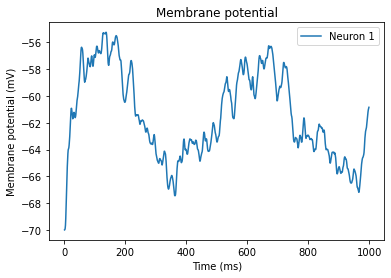

In [19]:
nest.voltage_trace.from_device(voltmeter);

In [20]:
nest.Simulate(4000)


Aug 30 02:19:44 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Aug 30 02:19:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 4000
    Number of OpenMP threads: 1
    Not using MPI

Aug 30 02:19:44 SimulationManager::run [Info]: 
    Simulation finished.


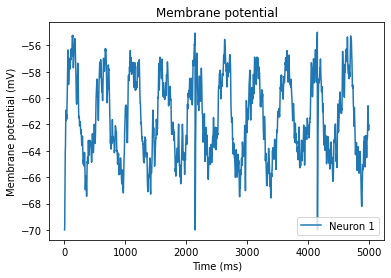

In [21]:
nest.voltage_trace.from_device(voltmeter);

### Inspecting the connections

`GetConnections()` returns a list with one element per connection, each element having the following structure
1. GID of sender
1. GID of target
1. Target thread
1. Synapse-type id
1. Port number

In [22]:
conns = nest.GetConnections()
conns

To find out more about the connection properties, we use `GetStatus()`

In [23]:
nest.GetStatus(conns)

({'delay': 1.0,
  'port': 0,
  'receptor': 0,
  'sizeof': 32,
  'source': 2,
  'synapse_id': 18,
  'synapse_model': 'static_synapse',
  'target': 1,
  'target_thread': 0,
  'weight': 1.0},
 {'delay': 1.0,
  'port': 0,
  'receptor': 0,
  'sizeof': 32,
  'source': 3,
  'synapse_id': 18,
  'synapse_model': 'static_synapse',
  'target': 1,
  'target_thread': 0,
  'weight': 2.0},
 {'delay': 1.0,
  'port': 0,
  'receptor': 0,
  'sizeof': 32,
  'source': 4,
  'synapse_id': 18,
  'synapse_model': 'static_synapse',
  'target': 1,
  'target_thread': 0,
  'weight': -5.0},
 {'delay': 1.0,
  'port': 0,
  'receptor': 1,
  'sizeof': 32,
  'source': 5,
  'synapse_id': 18,
  'synapse_model': 'static_synapse',
  'target': 1,
  'target_thread': 0,
  'weight': 1.0})

- This is a bit messy, so we clean it up

In [24]:
for syn in nest.GetStatus(conns):
    print("""
          Source: {source}
          Target: {target}
          Model : {synapse_model}
          Weight: {weight} pA
          Delay : {delay} ms""".format(**syn))


          Source: 2
          Target: 1
          Model : static_synapse
          Weight: 1.0 pA
          Delay : 1.0 ms

          Source: 3
          Target: 1
          Model : static_synapse
          Weight: 2.0 pA
          Delay : 1.0 ms

          Source: 4
          Target: 1
          Model : static_synapse
          Weight: -5.0 pA
          Delay : 1.0 ms

          Source: 5
          Target: 1
          Model : static_synapse
          Weight: 1.0 pA
          Delay : 1.0 ms


### Using Pandas with NEST

- Pandas is a powerful tool for managing and analysing large amounts of data
- Data returned by NEST can in many cases be easily converted to Pandas dataframes
- To first approximation, Pandas dataframes work like NumPy arrays with named columns

#### Extracting connection data

- We use the same `GetStatus()` call as above
- We obtain a tuple with one dictionary per connection
- We can convert this directly into a dataframe
- If we `print` the data, we get an ASCII-pretty-printed table

In [27]:
conn_data = pd.DataFrame.from_records(nest.GetStatus(conns))
print(conn_data)

   delay  port  receptor  sizeof  source  synapse_id   synapse_model  target  \
0    1.0     0         0      32       2          18  static_synapse       1   
1    1.0     0         0      32       3          18  static_synapse       1   
2    1.0     0         0      32       4          18  static_synapse       1   
3    1.0     0         1      32       5          18  static_synapse       1   

   target_thread  weight  
0              0     1.0  
1              0     2.0  
2              0    -5.0  
3              0     1.0  


- If we just display the dataframe in the Notebook, we get a nicely formatted table

In [28]:
conn_data

,delay,port,receptor,sizeof,source,synapse_id,synapse_model,target,target_thread,weight
0,1.0,0,0,32,2,18,static_synapse,1,0,1.0
1,1.0,0,0,32,3,18,static_synapse,1,0,2.0
2,1.0,0,0,32,4,18,static_synapse,1,0,-5.0
3,1.0,0,1,32,5,18,static_synapse,1,0,1.0


- We can even get $\LaTeX$ code

In [22]:
print(conn_data.to_latex())

\begin{tabular}{lrrrrlrr}
\toprule
{} &  delay &  receptor &  sizeof &  source &   synapse\_model &  target &  weight \\
\midrule
0 &    1.0 &         0 &      32 &       2 &  static\_synapse &       1 &     1.0 \\
1 &    1.0 &         0 &      32 &       3 &  static\_synapse &       1 &     2.0 \\
2 &    1.0 &         0 &      32 &       4 &  static\_synapse &       1 &    -5.0 \\
3 &    1.0 &         1 &      32 &       5 &  static\_synapse &       1 &     1.0 \\
\bottomrule
\end{tabular}



- By default, we get all properties of the connections
- We can also explicitly select only certain properties

In [23]:
properties = ('source', 'target', 'delay', 'weight')
conn_data = pd.DataFrame.from_records(
       list(nest.GetStatus(conns, keys=properties)), columns=properties)

conn_data

,source,target,delay,weight
0,2,1,1.0,1.0
1,3,1,1.0,2.0
2,4,1,1.0,-5.0
3,5,1,1.0,1.0


#### Plotting "manually"

- We can also extract data from recording devices into dataframes
- `voltmeter` is a single-element list (NEST commands take and return lists/tuples)
- Recorded data is in the `events` property of the voltmeter
- Data is recorded as a single-element tuple, we need to extract that element

In [29]:
vm_data = pd.DataFrame(nest.GetStatus(voltmeter, 'events')[0])

vm_data[:5]

,senders,times,V_m
0,1,1.0,-70.000000
1,1,2.0,-69.980036
2,1,3.0,-69.894440
3,1,4.0,-69.655373
4,1,5.0,-69.143218


- We can obtain statistics on the data (here, meaningful for $V_m$ only)

In [30]:
vm_data.describe()

,senders,times,V_m
count,4999.0,4999.000000,4999.000000
mean,1.0,2500.000000,-61.469683
std,0.0,1443.231328,3.016184
min,1.0,1.000000,-70.000000
25%,1.0,1250.500000,-63.983108
50%,1.0,2500.000000,-61.856275
75%,1.0,3749.500000,-58.737964
max,1.0,4999.000000,-55.006970


- We can plot using the `plot()` method of the Pandas DataFrame object ([more on plotting in Pandas](http://pandas-docs.github.io/pandas-docs-travis/user_guide/visualization.html))

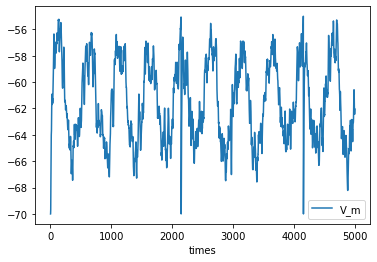

In [31]:
vm_data.plot(x='times', y='V_m');

- We can plot using the normal `plot()` command

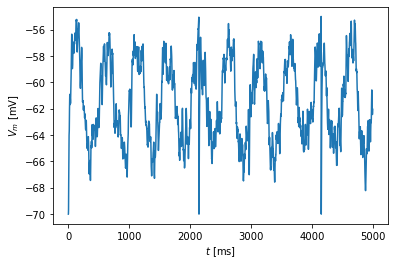

In [32]:
plt.plot(vm_data.times, vm_data.V_m)
plt.xlabel('$t$ [ms]')
plt.ylabel('$V_m$ [mV]');

## The Brunel Network: A sparsely connected network

* $N_E=8000$ excitatory neurons
* $N_I=2000$ inhibitory neurons
* 10% connectivity
* Scaling parameter allows adjustment of network size for faster testing (changes dynamics)
* N. Brunel, J Comput Neurosci 8:183 (2000)

![Brunel](figures/brunel_detailed_external_single2.svg)

### Define parameters

In [40]:
nest.ResetKernel()

# Network parameters. These are given in Brunel (2000) J.Comp.Neuro.
g       = 5.0    # Ratio of IPSP to EPSP amplitude: J_I/J_E
eta     = 2.0    # rate of external population in multiples of threshold rate
delay   = 1.5    # synaptic delay in ms
tau_m   = 20.0   # Membrane time constant in ms
V_th    = 20.0   # Spike threshold in mV

scale = 1.0
N_E = int(scale * 8000)
N_I = int(scale * 2000)
N_neurons = N_E + N_I

C_E    = int(N_E/10) # number of excitatory synapses per neuron
C_I    = int(N_I/10) # number of inhibitory synapses per neuron

J_E  = 0.1
J_I  = -g*J_E

nu_ex  = eta*V_th/(J_E*C_E*tau_m)  # rate of an external neuron in ms^-1
p_rate = 1000.0*nu_ex*C_E          # rate of the external population in s^-1

### Configure kernel and neuron defaults

In [41]:
nest.SetKernelStatus({"print_time": True})

nest.SetDefaults("iaf_psc_delta", 
                 {"C_m": 1.0,
                  "tau_m": tau_m,
                  "t_ref": 2.0,
                  "E_L": 0.0,
                  "V_th": V_th,
                  "V_reset": 10.0})

### Create neurons

In [42]:
nodes   = nest.Create("iaf_psc_delta", N_neurons)
nodes_E = nodes[:N_E]
nodes_I = nodes[N_E:]

### Connect neurons with each other

In [43]:
nest.CopyModel("static_synapse", "excitatory",
               {"weight":J_E, "delay":delay})

nest.Connect(nodes_E, nodes,
             {"rule": 'fixed_indegree', "indegree": C_E},
             "excitatory")

nest.CopyModel("static_synapse", "inhibitory",
               {"weight":J_I, "delay":delay})

nest.Connect(nodes_I, nodes,
             {"rule": 'fixed_indegree', "indegree": C_I},
             "inhibitory")

### Add stimulation and recording devices

In [44]:
noise = nest.Create("poisson_generator", params={"rate": p_rate})

# connect using all_to_all: one noise generator to all neurons
nest.Connect(noise, nodes, syn_spec="excitatory")

spikes=nest.Create("spike_recorder", 2, 
                   params=[{"label": "Exc"}, 
                           {"label": "Inh"}])
spikes_E = spikes[:1]
spikes_I = spikes[1:]

N_rec = 100   # Number of neurons to record from

# connect using all_to_all: all recorded excitatory neurons to one detector
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

### Simulate

The simulation progress is shown in the terminal window in which you started `ipython notebook`.

In [45]:
simtime = 1000
nest.Simulate(simtime)


Aug 30 02:24:55 NodeManager::prepare_nodes [Info]: 
    Preparing 10003 nodes for simulation.

Aug 30 02:24:55 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 10003
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Not using MPI

[  32% ] Model time: 314.0 ms, Real-time factor: 19.2298

### Extract recorded data and display

#### Computing spike rates

In [47]:
events = nest.GetStatus(spikes, "n_events")

rate_ex= float(events[0])/simtime*1000/N_rec
print("Excitatory rate   : %.2f [1/s]" % rate_ex)

rate_in= float(events[1])/simtime*1000/N_rec
print("Inhibitory rate   : %.2f [1/s]" % rate_in)

Excitatory rate   : 41.39 [1/s]
Inhibitory rate   : 41.35 [1/s]


#### Visualization with raster_plot

In [63]:
nest.raster_plot._make_plot?

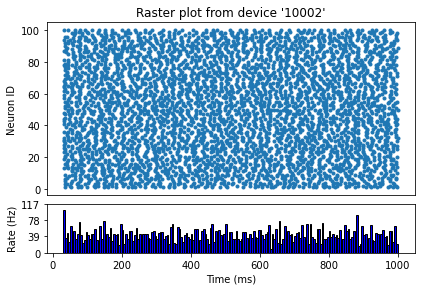

In [49]:
nest.raster_plot.from_device(spikes_E, hist=True);

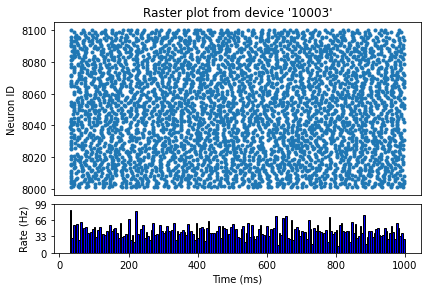

In [50]:
nest.raster_plot.from_device(spikes_I, hist=True);

#### Managing data with Pandas and plotting "manually"

In [51]:
sdE_data = pd.DataFrame(nest.GetStatus(spikes_E, 'events')[0])
sdI_data = pd.DataFrame(nest.GetStatus(spikes_I, 'events')[0])

In [52]:
sdE_data[:5].T

,0,1,2,3,4
senders,81.0,13.0,19.0,23.0,26.0
times,31.9,32.1,32.4,33.0,32.6


In [53]:
sdE_data.describe().T

,count,mean,std,min,25%,50%,75%,max
senders,4139.0,50.309737,28.829321,1.0,26.0,50.0,75.00,100.0
times,4139.0,512.474970,280.872637,31.9,268.9,511.3,754.55,1000.0


In [54]:
sdI_data.describe().T

,count,mean,std,min,25%,50%,75%,max
senders,4135.0,8050.452479,28.931079,8001.0,8025.00,8050.0,8076.0,8100.0
times,4135.0,513.647690,280.339646,31.7,272.95,511.7,755.7,998.1


##### Raster plot of spikes

- We plot sender GIDs vs spike times
- We only plot the first 40 excitatory neurons and the first 10 inhibitory neurons
- We need to offset the GIDs of the inhibitory neurons properly

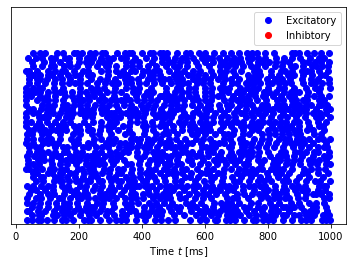

In [64]:
e_spikes_plot = sdE_data[sdE_data.senders <= 40]
i_spikes_plot = sdI_data[(2000 < sdI_data.senders) 
                         & (sdI_data.senders <= 2010)]

plt.plot(e_spikes_plot.times, e_spikes_plot.senders, 
         'bo', label='Excitatory')
plt.plot(i_spikes_plot.times, i_spikes_plot.senders-2000+40, 
         'ro', label='Inhibtory')
plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.yticks([])
plt.ylim(0, 51);

##### Spike-time histogram

- Explicit bins give us better control over binning
- We could also use NumPy's histogram function
- Histogram type `step` usually gives cleaner diagrams when we have many bins

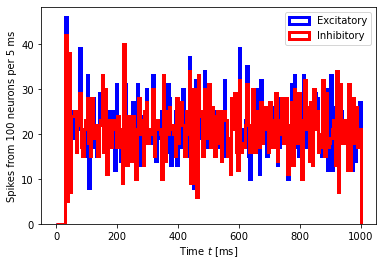

In [56]:
bins = np.arange(0., 1001., 5.)
plt.hist(sdE_data.times, bins=bins, histtype='step', lw=3, color='b', 
         label='Excitatory')
plt.hist(sdI_data.times, bins=bins, histtype='step', lw=3, color='r', 
         label='Inhibitory')
plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.ylabel('Spikes from 100 neurons per 5 ms');

##### Interspike-interval histograms

- We need to compute ISIs for each neuron separately
- We therefore first group the data by senders (we focus on excitatory spikes here)
- See also the [Pandas Groupby Documentation](http://pandas-docs.github.io/pandas-docs-travis/user_guide/groupby.html)

In [57]:
e_spk_grouped = sdE_data.groupby('senders')

- As a first step, let us look at the firing activity of the individual neurons

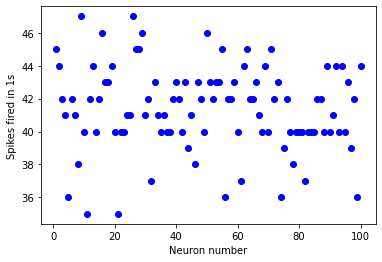

In [58]:
e_spk_grouped.size().plot(style='bo')
plt.xlabel('Neuron number')
plt.ylabel('Spikes fired in 1s');

- Now, let us histogram this data

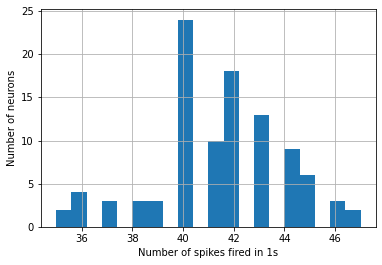

In [59]:
e_spk_grouped.size().hist(bins=20);
plt.xlabel('Number of spikes fired in 1s')
plt.ylabel('Number of neurons');

- We can now compute differences in spike times
- For the first spike of each neuron, we get a 'NaN' value, which we drop
- We thus get a data series of inter-spike interval

In [60]:
len(e_spk_grouped['times'].diff().dropna())

4039

In [61]:
e_spk_isi = e_spk_grouped['times'].diff().dropna()

- From that, we obtain the ISI histogram

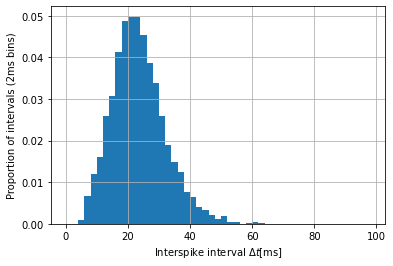

In [62]:
e_spk_isi.hist(bins=np.arange(0., 100., 2.), density=True)
plt.xlabel('Interspike interval $\Delta t$[ms]')
plt.ylabel('Proportion of intervals (2ms bins)');

## Randomizing Neurons and Synapses

### Parallelism in NEST

- NEST can combine MPI-based and thread-based parallelism
- The key concept in parallel NEST is the *virtual process* (VP)
    - For $N_M$ MPI processes with $N_T$ threads each, be have $$N_{VP}=N_M\times N_T$$ virtual processes
    - For fixed $N_{VP}$, a NEST simulation shall yield identical results, independent of how the virtual processes are divided into MPI processes and threads
    - Recording devices write one file per MPI process, data from those files have to be pooled
- In this notebook, we only use thread-based parallelism: $N_{VP}=N_T$, $N_M=1$

### Random numbers in NEST

Random numbers may be drawn in three ways in a NEST simulation

1. globally in NEST, e.g., when creating divergent connections;
1. in NEST parallel on all VPs, e.g., when creating convergent connections;
1. in the Python script, e.g., when passing randomized parameters to NEST.

#### Seeding random numbers

- We thus have $N_{VP}+1$ random number generators in NEST, and need to supply seeds for all.
- In general, we also need one Python RNG per VP, see Tutorial Sections 5 and 6.
- Since we use only a single MPI process, we need only a single Python random number generator.
- In total, we need $N_{VP}+2$ seeds
- We build our seeds from a master seed
- **NOTE**: For different simulations, you need to use master seeds at least $N_{VP}+2$ apart

### The Code

#### Preparations first

In [50]:
nest.ResetKernel()

# Number of virtual processes
n_vp = 4

# Master seed for simulation
master_seed = 12345

# Network parameters. These are given in Brunel (2000) J.Comp.Neuro.
g       = 7.0    # Ratio of IPSP to EPSP amplitude: J_I/J_E
eta     = 3.5    # rate of external population in multiples of threshold rate
delay   = 1.5    # synaptic delay in ms
tau_m   = 20.0   # Membrane time constant in mV
V_th    = 20.0   # Spike threshold in mV

scale = 1.
N_E = int(scale * 8000)
N_I = int(scale * 2000)
N_neurons = N_E + N_I

C_E    = int(N_E/10) # number of excitatory synapses per neuron
C_I    = int(N_I/10) # number of inhibitory synapses per neuron

J_E  = 0.1
J_I  = -g*J_E

nu_ex  = eta* V_th/(J_E*C_E*tau_m) # rate of an external neuron in ms^-1
p_rate = 1000.0*nu_ex*C_E          # rate of the external population in s^-1

# Limits for randomization
V_min, V_max = -V_th, V_th
w_min, w_max = 0.5 * J_E, 1.5 * J_E

#### Configure kernel, including seeding RNGs

In [51]:
seeds = range(master_seed, master_seed + n_vp + 2)

pyrng = np.random.RandomState(seeds[0])

nest.SetKernelStatus({'print_time': True,
                      'local_num_threads': n_vp,
                      'grng_seed': seeds[1],
                      'rng_seeds': seeds[2:]})

nest.SetDefaults("iaf_psc_delta", 
                 {"C_m": 1.0,
                  "tau_m": tau_m,
                  "t_ref": 2.0,
                  "E_L": 0.0,
                  "V_th": V_th,
                  "V_reset": 10.0})

#### Creating neurons with randomized membrane potential

- We need to create the neurons first, then randomize $V_m$ uniformly over $[V_{\textrm{min}}, V_{\textrm{max}})$
- We use a variant of `SetStatus()` that allows us to pass one value per node
- **Note**: This code is inefficient when using many MPI processes

In [52]:
nodes   = nest.Create("iaf_psc_delta", N_neurons)
nodes_E = nodes[:N_E]
nodes_I = nodes[N_E:]

nest.SetStatus(nodes, params='V_m', 
               val=pyrng.uniform(low=V_min, high=V_max, 
                                 size=(N_neurons,)))

#### Connecting with randomized weights

- We exploit that `Connect()` can draw random weights
- We only randomize outgoing connections from the excitatory neurons
- Random numbers are drawn from NEST's per-VP RNGs

In [53]:
nest.CopyModel("static_synapse", "excitatory",
               {"weight":J_E, "delay":delay})

nest.Connect(nodes_E, nodes,
             {"rule": 'fixed_indegree', "indegree": C_E},
             {"model": "excitatory",
              "weight": {"distribution": "uniform",
                         "low": w_min,
                         "high": w_max}})

nest.CopyModel("static_synapse", "inhibitory",
               {"weight":J_I, "delay":delay})

nest.Connect(nodes_I, nodes,
             {"rule": 'fixed_indegree', "indegree": C_I},
             "inhibitory")

#### Adding stimulation and recording devices

- Same as before

In [54]:
noise = nest.Create("poisson_generator", params={"rate": p_rate})

# connect using all_to_all: one noise generator to all neurons
nest.Connect(noise, nodes, syn_spec="excitatory")

spikes=nest.Create("spike_detector", 2, 
                   params=[{"label": "Exc", "to_file": False}, 
                           {"label": "Inh", "to_file": False}])
spikes_E = spikes[:1]
spikes_I = spikes[1:]

N_rec   = 100   # Number of neurons to record from

# connect using all_to_all: all recorded excitatory neurons to one detector
nest.Connect(nodes_E[:N_rec], spikes_E)
nest.Connect(nodes_I[:N_rec], spikes_I)

### Inspecting the Network

#### Initial membrane potentials

- Read out $V_m$ from all neurons
- Plot as scatter plot and histogram

In [55]:
vm_ini = np.array(nest.GetStatus(nodes, 'V_m'))

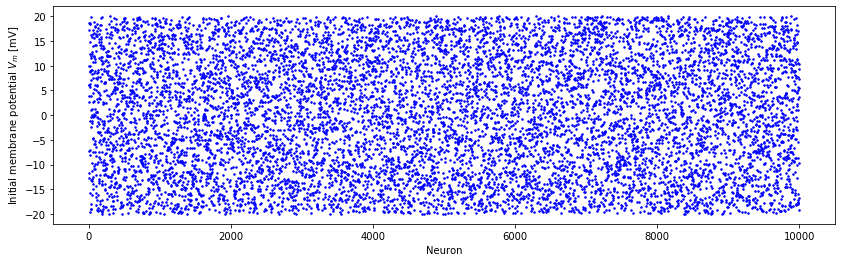

In [56]:
plt.plot(vm_ini, 'b.', markersize=3)
plt.xlabel('Neuron')
plt.ylabel('Initial membrane potential $V_m$ [mV]');

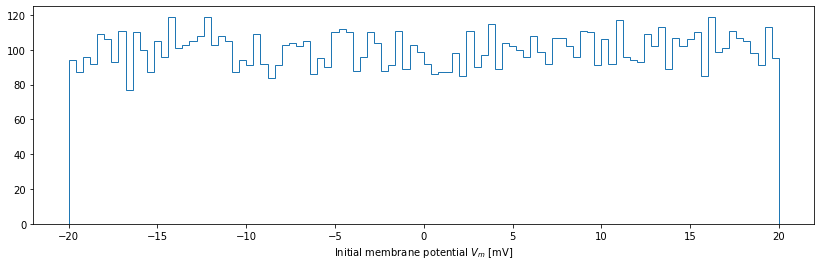

In [57]:
plt.hist(vm_ini, bins=100, histtype='step')
plt.xlabel('Initial membrane potential $V_m$ [mV]');

#### Synaptic weights

- We collect data on all outgoing synapses of type "excitatory"
- For the first 1000 neurons only
- We store as Pandas data frame

In [58]:
exc_conns = nest.GetConnections(source=nodes_E[:1000], 
                                synapse_model='excitatory')
exc_weights = pd.DataFrame({'weight': nest.GetStatus(exc_conns, 'weight')})

exc_weights.describe().T

,count,mean,std,min,25%,50%,75%,max
weight,1001230.0,0.100016,0.028874,0.05,0.075053,0.099968,0.125006,0.15


- We scatter plot the first 1000
- We create a histogram of all

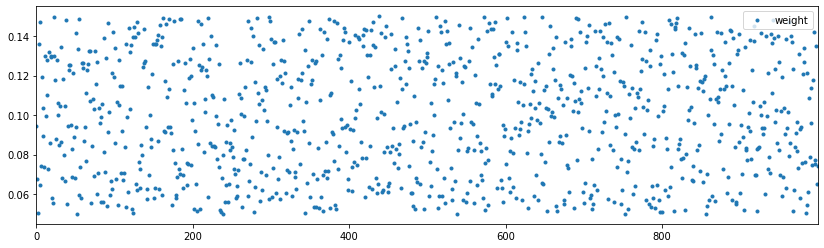

In [59]:
exc_weights[:1000].plot(style='.');

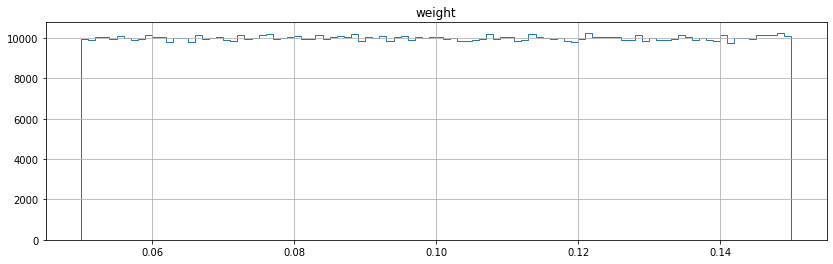

In [60]:
exc_weights.hist(bins=100, histtype='step');

### Simulating the network

In [61]:
nest.Simulate(1000)

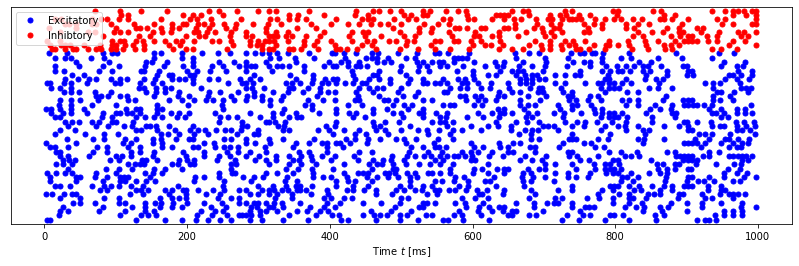

In [62]:
sdE_data = pd.DataFrame(nest.GetStatus(spikes_E, 'events')[0])
sdI_data = pd.DataFrame(nest.GetStatus(spikes_I, 'events')[0])

e_spikes_plot = sdE_data[sdE_data.senders <= 40]
i_spikes_plot = sdI_data[(8000 < sdI_data.senders) 
                         & (sdI_data.senders <= 8010)]

plt.plot(e_spikes_plot.times, e_spikes_plot.senders, 'bo', 
         markersize=5, label='Excitatory')
plt.plot(i_spikes_plot.times, i_spikes_plot.senders-8000+40, 'ro', 
         markersize=5, label='Inhibtory')
plt.legend()
plt.xlabel('Time $t$ [ms]')
plt.yticks([])
plt.ylim(0, 51);